In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [2]:
from ogb.nodeproppred import PygNodePropPredDataset

dataset = PygNodePropPredDataset(name = "ogbn-mag") 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph = dataset[0]

Using backend: pytorch


In [3]:
graph

Data(
  edge_index_dict={
    ('author', 'affiliated_with', 'institution')=[2, 1043998],
    ('author', 'writes', 'paper')=[2, 7145660],
    ('paper', 'cites', 'paper')=[2, 5416271],
    ('paper', 'has_topic', 'field_of_study')=[2, 7505078]
  },
  edge_reltype={
    ('author', 'affiliated_with', 'institution')=[1043998, 1],
    ('author', 'writes', 'paper')=[7145660, 1],
    ('paper', 'cites', 'paper')=[5416271, 1],
    ('paper', 'has_topic', 'field_of_study')=[7505078, 1]
  },
  node_year={
    paper=[736389, 1]
  },
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389
  },
  x_dict={
    paper=[736389, 128]
  },
  y_dict={
    paper=[736389, 1]
  }
)

In [4]:
print(np.unique(graph['edge_reltype'][('paper', 'has_topic', 'field_of_study')]))

[2]


In [5]:
graph['edge_index_dict'][('paper', 'has_topic', 'field_of_study')]

tensor([[     0,      0,      0,  ..., 736388, 736388, 736388],
        [   145,   2215,   3205,  ...,  21458,  22283,  31934]])

In [6]:
graph['edge_index_dict'][('author', 'writes', 'paper')]

tensor([[      0,       0,       0,  ..., 1134647, 1134648, 1134648],
        [  19703,  289285,  311768,  ...,  657395,  671118,  719594]])

In [7]:
nodes = np.arange(sum([val for val in graph['num_nodes_dict'].values()]))
node_types = []

In [8]:
type_order = ["paper", "author", "field_of_study", "institution"]

In [9]:
from collections import defaultdict
old2newidx = defaultdict(dict)
curr = 0
for tidx, key in enumerate(type_order):
    for idx_old in range(graph['num_nodes_dict'][key]):
        old2newidx[key][idx_old] = curr
        curr += 1
        node_types += [tidx]
node_types = np.asarray(node_types)

In [10]:
old2newidx['field_of_study']

{0: 1871038,
 1: 1871039,
 2: 1871040,
 3: 1871041,
 4: 1871042,
 5: 1871043,
 6: 1871044,
 7: 1871045,
 8: 1871046,
 9: 1871047,
 10: 1871048,
 11: 1871049,
 12: 1871050,
 13: 1871051,
 14: 1871052,
 15: 1871053,
 16: 1871054,
 17: 1871055,
 18: 1871056,
 19: 1871057,
 20: 1871058,
 21: 1871059,
 22: 1871060,
 23: 1871061,
 24: 1871062,
 25: 1871063,
 26: 1871064,
 27: 1871065,
 28: 1871066,
 29: 1871067,
 30: 1871068,
 31: 1871069,
 32: 1871070,
 33: 1871071,
 34: 1871072,
 35: 1871073,
 36: 1871074,
 37: 1871075,
 38: 1871076,
 39: 1871077,
 40: 1871078,
 41: 1871079,
 42: 1871080,
 43: 1871081,
 44: 1871082,
 45: 1871083,
 46: 1871084,
 47: 1871085,
 48: 1871086,
 49: 1871087,
 50: 1871088,
 51: 1871089,
 52: 1871090,
 53: 1871091,
 54: 1871092,
 55: 1871093,
 56: 1871094,
 57: 1871095,
 58: 1871096,
 59: 1871097,
 60: 1871098,
 61: 1871099,
 62: 1871100,
 63: 1871101,
 64: 1871102,
 65: 1871103,
 66: 1871104,
 67: 1871105,
 68: 1871106,
 69: 1871107,
 70: 1871108,
 71: 1871109,
 7

In [11]:
(node_types==0).sum()

736389

In [51]:
edge_index = graph['edge_index_dict'] 
edge_reltype= graph['edge_reltype']
edges = []
edge_types = []
edge_type_dict = {}
for key in edge_index.keys():
    curr_edges = edge_index[key].detach().numpy().T
    curr_type = edge_reltype[key].squeeze().detach().numpy().tolist()
    for edge in curr_edges:
        e0 = old2newidx[key[0]][edge[0]]
        e1 = old2newidx[key[2]][edge[1]]
        edges += [[e0, e1], [e1, e0]]
        edge_type_dict[(e0, e1)] = curr_type[0]
        edge_type_dict[(e1, e0)] = curr_type[0]
    edge_types += 2*curr_type

In [52]:
import networkx as nx
from networkx.generators.ego import ego_graph
import tqdm

In [53]:
g = nx.Graph()

In [54]:
g.add_nodes_from(nodes.tolist())
g.add_edges_from(edges)

In [55]:
eg = ego_graph(g, 24323, radius=1)

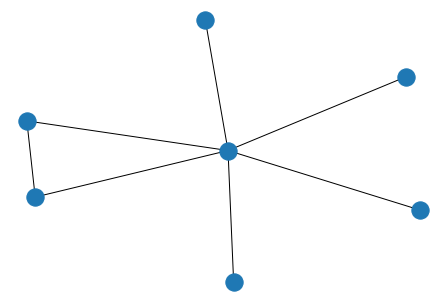

In [56]:
nx.draw(eg)

In [57]:
len(eg.nodes)

7

In [58]:
len(eg.edges)

7

In [98]:
import dfs_code
import torch

In [102]:
def ego2data(idx, ego):
    d = {}
    d['idx'] = idx
    i2i = {iold: inew for inew, iold in enumerate(ego.nodes)}
    edges = []
    elabels = []
    for e in ego.edges:
        edges += [[i2i[e[0]], i2i[e[1]]], [i2i[e[1]], i2i[e[0]]]]
        elabels += 2*[edge_type_dict[tuple(e)]]
    d['edge_index'] = torch.tensor(np.asarray(edges)).T
    d['node_labels'] = node_types[np.asarray(ego.nodes)]
    d['edge_labels'] = np.asarray(elabels)
    d['graph_features'] = graph['x_dict']['paper'][idx].numpy()
    d['y'] = graph['y_dict']['paper'][idx].item()
    return ConfigDict(d)

In [111]:
data = {}
for idx in tqdm.tqdm(nodes[node_types == 0]):
    d = ego2data(idx, ego_graph(g, idx, radius=1))
    try:
        code, dfs_index = dfs_code.min_dfs_code_from_torch_geometric(d, d['node_labels'].tolist(), 
                                                                    d['edge_labels'].tolist(),
                                                                    timeout=1) 
        d.min_dfs_code = np.asarray(code)
        d.dfs_index = np.asarray(dfs_index)
        data[idx] = d
    except KeyError:
        continue

  0%|▏                                                                                                                                                                    | 921/736389 [11:28<152:42:01,  1.34it/s]


KeyboardInterrupt: 